In [1]:
import pythetatools.toyxp as toyxp
import pythetatools.likelihood as likelihood
from pythetatools.global_names import *
from pythetatools.base_visualisation import *
from pythetatools.file_manager import read_histogram, download
from pythetatools.base_analysis import critical_value_for_cl

from scipy.interpolate import interp1d
from collections import defaultdict
import shutil
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import uproot
import matplotlib.colors as colors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

In [2]:
%load_ext autoreload
%autoreload 2

# Download if necessary

In [45]:
delta_values = ['0.0', '0.392699081699', '-0.785398163397', '0.785398163397',
                '-1.57079632679', '1.57079632679', '-2.35619449019', '2.35619449019',
                '2.59181393921', '3.14159265359' ]

sin223_values = ['0.42', '0.44', '0.46', '0.48', '0.5', '0.52', '0.54', '0.56', '0.58', '0.6', '0.62']
param_name = 'sin223'
param_values = {'delta':delta_values, 'sin223':sin223_values}
true_mh = 1
postfix = {'delta':'_23', 'sin223':'_Sin223_23_new'}
suffix = {'delta':'', 'sin223':'sin223'}

In [46]:
for param_value in param_values[param_name]:
    basename_directory = f"MargTemplates_LucileThesis_fit_FC{suffix[param_name]}_{param_value}_{true_mh}_FullSyst_wRC_etheta_ptheta_{param_name}"

    input_path = f"/sps/t2k/Archive_OA2023_ToKeep/FC/output_FC{postfix[param_name]}/{basename_directory}/MergeToyMargTemplates"
    dir_ver = 'OA2023'
    patern = '*.root'
    destination = f"{inputs_dir}/{dir_ver}/FC/{basename_directory}"

    download(input_path, destination, new_name='', pattern=patern, login=my_login, domain=my_domain, overwrite=False)

directory
Created destination folder: /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/FC/MargTemplates_LucileThesis_fit_FCsin223_0.42_1_FullSyst_wRC_etheta_ptheta_sin223
Executing: rsync -ah --progress --include='*.root' --exclude='*' dcarabad@cca.in2p3.fr:/sps/t2k/Archive_OA2023_ToKeep/FC/output_FC_Sin223_23_new/MargTemplates_LucileThesis_fit_FCsin223_0.42_1_FullSyst_wRC_etheta_ptheta_sin223/MergeToyMargTemplates/ /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/FC/MargTemplates_LucileThesis_fit_FCsin223_0.42_1_FullSyst_wRC_etheta_ptheta_sin223/
receiving file list ... 
2 files to consider
./
margtemplates_merged.root
     100.96M 100%    7.48MB/s    0:00:12 (xfer#1, to-check=0/2)

sent 63 bytes  received 100.99M bytes  7.48M bytes/sec
total size is 100.96M  speedup is 1.00
directory
Created destination folder: /Users/denis.carabadjac/Python/pythetatools/inputs/OA2023/FC/MargTemplates_LucileThesis_fit_FCsin223_0.44_1_FullSyst_wRC_etheta_ptheta_sin223
Executing: rsyn

In [38]:
def read_files(file_pattern):
    grid, avnllh, param_name = likelihood.load(file_pattern)

    AvNLL_pergrid_pertoy = np.stack([avnllh[0], avnllh[1]], axis=1)
    grid_x = grid[0]
    param_name_x = param_name[0]

    return grid_x, param_name_x, AvNLL_pergrid_pertoy

def quadr(x, a, b, c):
    return a*x**2 + b*x + c

def find_parabold_ymin(x1, x2, x3, y1, y2, y3):
    h = x3-x2
    a = ((y3+y1)/2. - y2)/(h*h)
    b = ((y3-y1)/2. - 2.*a*h*x2)/h
    c = y2 - a*x2**2 - b*x2
    xmin = -b/(2.*a)
    return quadr(xmin, a, b, c)


def find_minimum_pertoy_forgivenmh(AvNLL_pergrid_pertoy, mh, param_name):
    index_x0_central = np.argmin(AvNLL_pergrid_pertoy[:, mh, :], axis=1) 
    avnll_pertoy_central = AvNLL_pergrid_pertoy[np.arange(AvNLL_pergrid_pertoy.shape[0]), mh, index_x0_central]
    x0_central = grid_x[index_x0_central]


    if param_name == 'delta':
        grid_x_extended_left = np.concatenate([[2*grid_x[0] - grid_x[1]], grid_x[:-1]])
        grid_x_extended_right = np.concatenate([grid_x[1:], [2*grid_x[-1] - grid_x[-2]]])

        index_x0_left = np.argmin(AvNLL_pergrid_pertoy[:, mh, :], axis=1) - 1
        index_x0_left = np.where(index_x0_left < 0, 50 + index_x0_left, index_x0_left) 
        avnll_pertoy_left = AvNLL_pergrid_pertoy[np.arange(AvNLL_pergrid_pertoy.shape[0]), mh, index_x0_left]
        x0_left = grid_x_extended_left[index_x0_central]
        
        index_x0_right = np.argmin(AvNLL_pergrid_pertoy[:, mh, :], axis=1) + 1
        index_x0_right = np.where(index_x0_right > 50, index_x0_right-50, index_x0_right) 
        avnll_pertoy_right = AvNLL_pergrid_pertoy[np.arange(AvNLL_pergrid_pertoy.shape[0]), mh, index_x0_right]
        x0_right = grid_x_extended_right[index_x0_central]
    else:
        index_x0_left = np.argmin(AvNLL_pergrid_pertoy[:, mh, :], axis=1) - 1
        x0_left = grid_x[index_x0_left]
        avnll_pertoy_left = AvNLL_pergrid_pertoy[np.arange(AvNLL_pergrid_pertoy.shape[0]), mh, index_x0_left]
        index_x0_right = np.argmin(AvNLL_pergrid_pertoy[:, mh, :], axis=1) + 1
        x0_right = grid_x[index_x0_right]
        avnll_pertoy_right = AvNLL_pergrid_pertoy[np.arange(AvNLL_pergrid_pertoy.shape[0]), mh, index_x0_right]    
    
    result = find_parabold_ymin(x0_left, x0_central, x0_right,
                            avnll_pertoy_left, avnll_pertoy_central, avnll_pertoy_right)
    return result
    
def find_minimum_pertoy(AvNLL_pergrid_pertoy, param_name):
    AvNLL_minimum_pertoy_permh = np.vstack([find_minimum_pertoy_forgivenmh(AvNLL_pergrid_pertoy, 0, param_name), find_minimum_pertoy_forgivenmh(AvNLL_pergrid_pertoy, 1, param_name)]).T
    AvNLL_minimum_pertoy = np.min(AvNLL_minimum_pertoy_permh, axis=1)
    return AvNLL_minimum_pertoy


def llr_distr(grid_x, AvNLL_pergrid_pertoy, true_param_value, true_mh, param_name):
    AvNLL_minimum_pertoy = find_minimum_pertoy(AvNLL_pergrid_pertoy, param_name)
    f = interp1d(grid_x, AvNLL_pergrid_pertoy[:, true_mh, :], axis=1, fill_value='extrapolate')
    return 2*(f(true_param_value) - AvNLL_minimum_pertoy)

def get_eff_error(target_eff, ntoys, upper):
    """
    Computes the Wilson score interval for a binomial distribution.

    Returns the binomial probability p for ntoys trials, where target_eff (t) 
    lies at the edge of the mean(P) ± standard deviation(P).

    Formulas:
      - Mean value: mean(P) = p
      - Standard deviation: sd(P) = sqrt[p(1 - p) / ntoys]
      - target_eff is expressed as: t = p ± sqrt[p(1 - p) / ntoys]
      - This leads to the quadratic equation:
        (t - p)^2 = p(1 - p) / ntoys
        (1 + 1/ntoys) * p^2 - (2t + 1/ntoys) * p + t^2 = 0
      - Solving for p in the form: a * p^2 + b * p + c = 0

    Parameters:
    ----------
    target_eff : float
        Target efficiency (t).
    ntoys : int
        Total number of trials (toys).
    upper : int
        If 1, returns the upper bound of the confidence interval.
        If 0, returns the lower bound.

    Returns:
    -------
    float
        The boundary of the confidence interval.
    """
    
    if ntoys <= 0:
        ValueError ("{ntoys} mush be greater than 1")
    
    a = 1.0 + 1.0 / ntoys
    b = -(2.0 * target_eff + 1.0 / ntoys)
    c = target_eff ** 2
    
    delta = b ** 2 - 4.0 * a * c
    if delta < 0:
        return -1
    
    sqrt_delta = np.sqrt(delta)
    if upper == 1:
        return (-b - sqrt_delta) / (2.0 * a)
    else:
        return (-b + sqrt_delta) / (2.0 * a)

def find_crit_val(dchi2, levels):
    ntoys = len(dchi2)
    dchi2_sorted = np.sort(dchi2)
    crit_val_centrals = []
    crit_val_uppers = []
    crit_val_lowers = []
    
    for level in levels:
        dchi2crit_id = int(len(dchi2_sorted)*level)
        crit_val_centrals.append(dchi2_sorted[dchi2crit_id])
        crit_val_uppers.append(dchi2_sorted[int(get_eff_error(dchi2crit_id/ntoys, ntoys, 0)*ntoys)])
        crit_val_lowers.append(dchi2_sorted[int(get_eff_error(dchi2crit_id/ntoys, ntoys, 1)*ntoys)])

    return crit_val_centrals, crit_val_lowers, crit_val_uppers

def plot_dchi2_distr(grid_x, dchi2, param_name_x, true_param, true_mh, levels, crit_val_centrals):

    fig, ax = plt.subplots()
    ax.hist(dchi2, bins=20, color=mo_to_color[true_mh], zorder=0)
    for level, ls, label, crit_val_central in zip(levels, lss, labels, crit_val_centrals):
        ax.axvline(crit_val_central, color='black', ls=ls, label=label+r' $\Delta \chi^2_{c}$='+f'{round(crit_val_central, 2)}')

    ax.set_title('True ' +osc_param_title[param_name_x][0]+f' = {round(true_param, 2)}; True {mo_to_title[true_mh]}', loc='right')
    ax.set_xlabel("$\Delta \chi^2$")
    ax.set_xlim(0, 20)
    show_minor_ticks(ax)
    ax.legend(framealpha=0)
    fig.savefig(f'{outputs_dir}/plots/{dir_ver}/FC/FC_dchi2_distr_{param_name_x}_{true_param}_truemh{true_mh}.pdf', bbox_inches='tight')
    

# Read the MargTemplates. Specify true_mh, true_param and filepath

In [21]:
mo_to_color = {0:darkblue, 1:darkorange}
mo_to_title = {0:'NO', 1:'IO'}

Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']
Number of entries in 'MargTemplate': 3240000.
Grid sizes: [81] for parameters ['sin223']


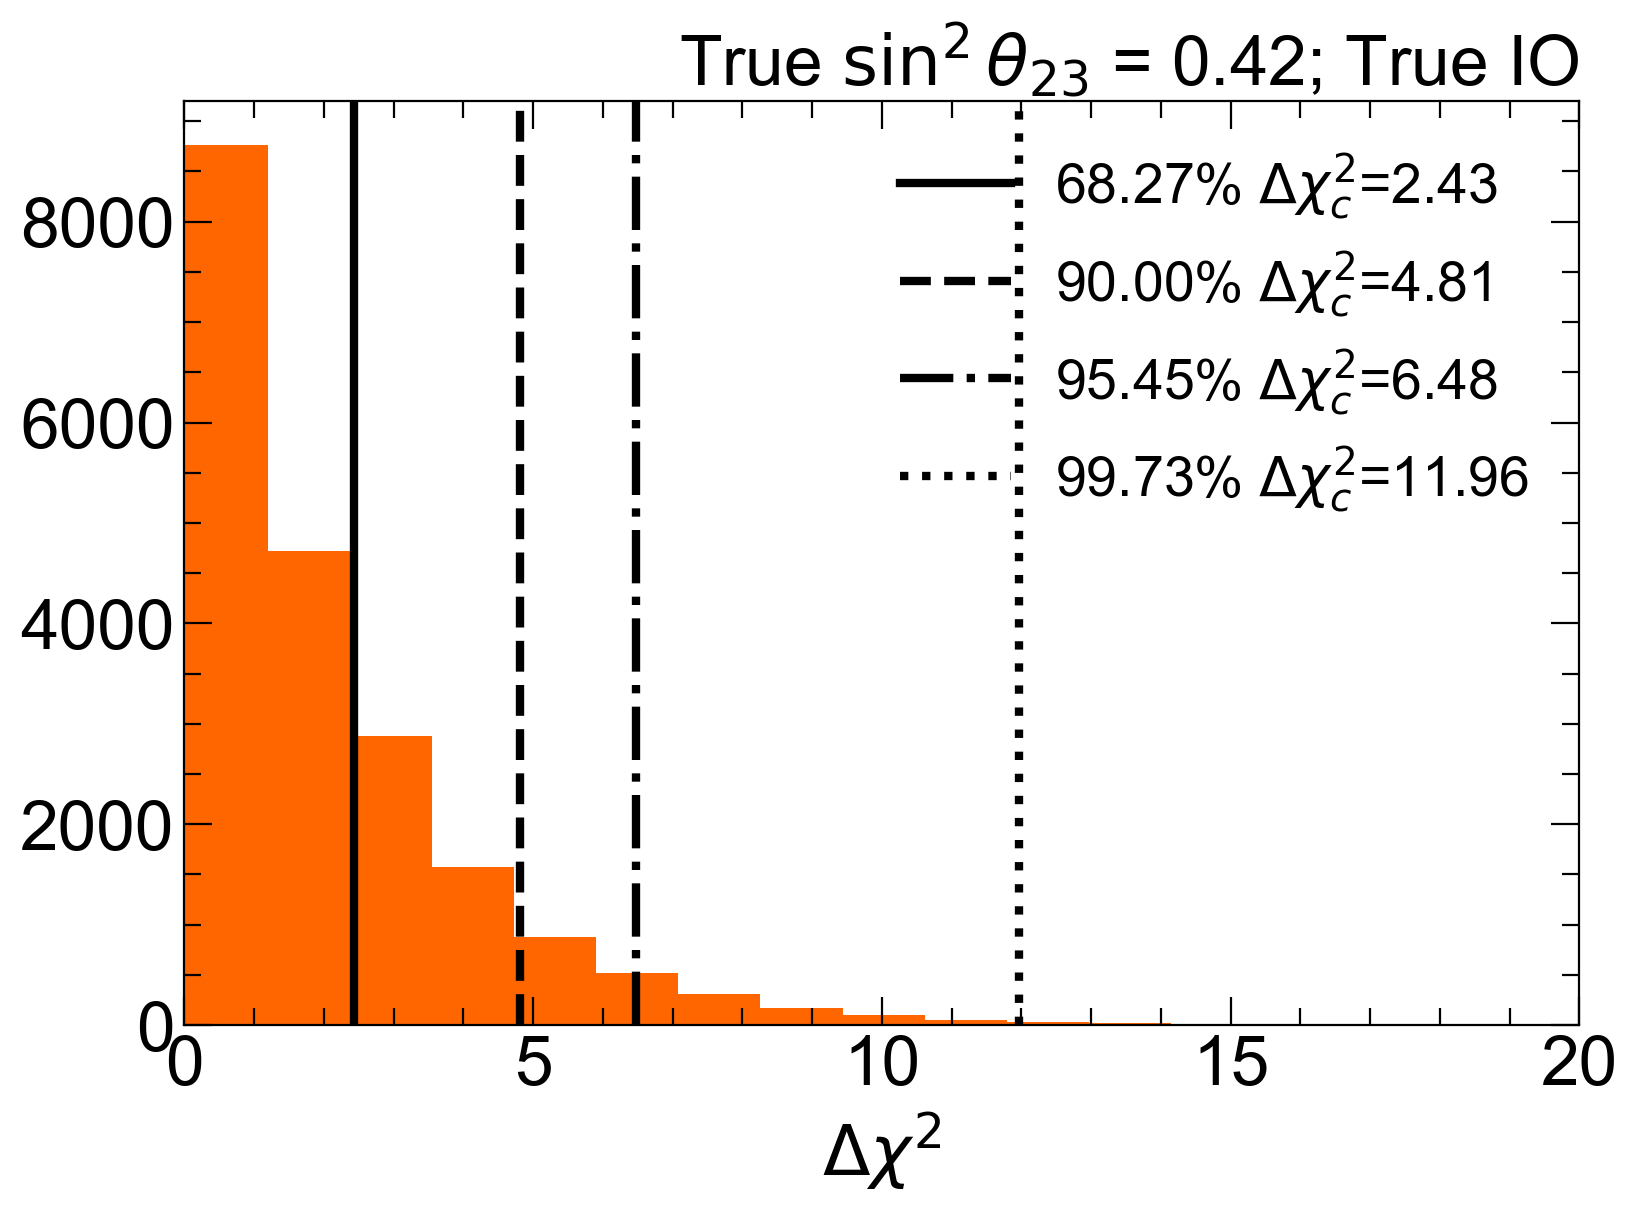

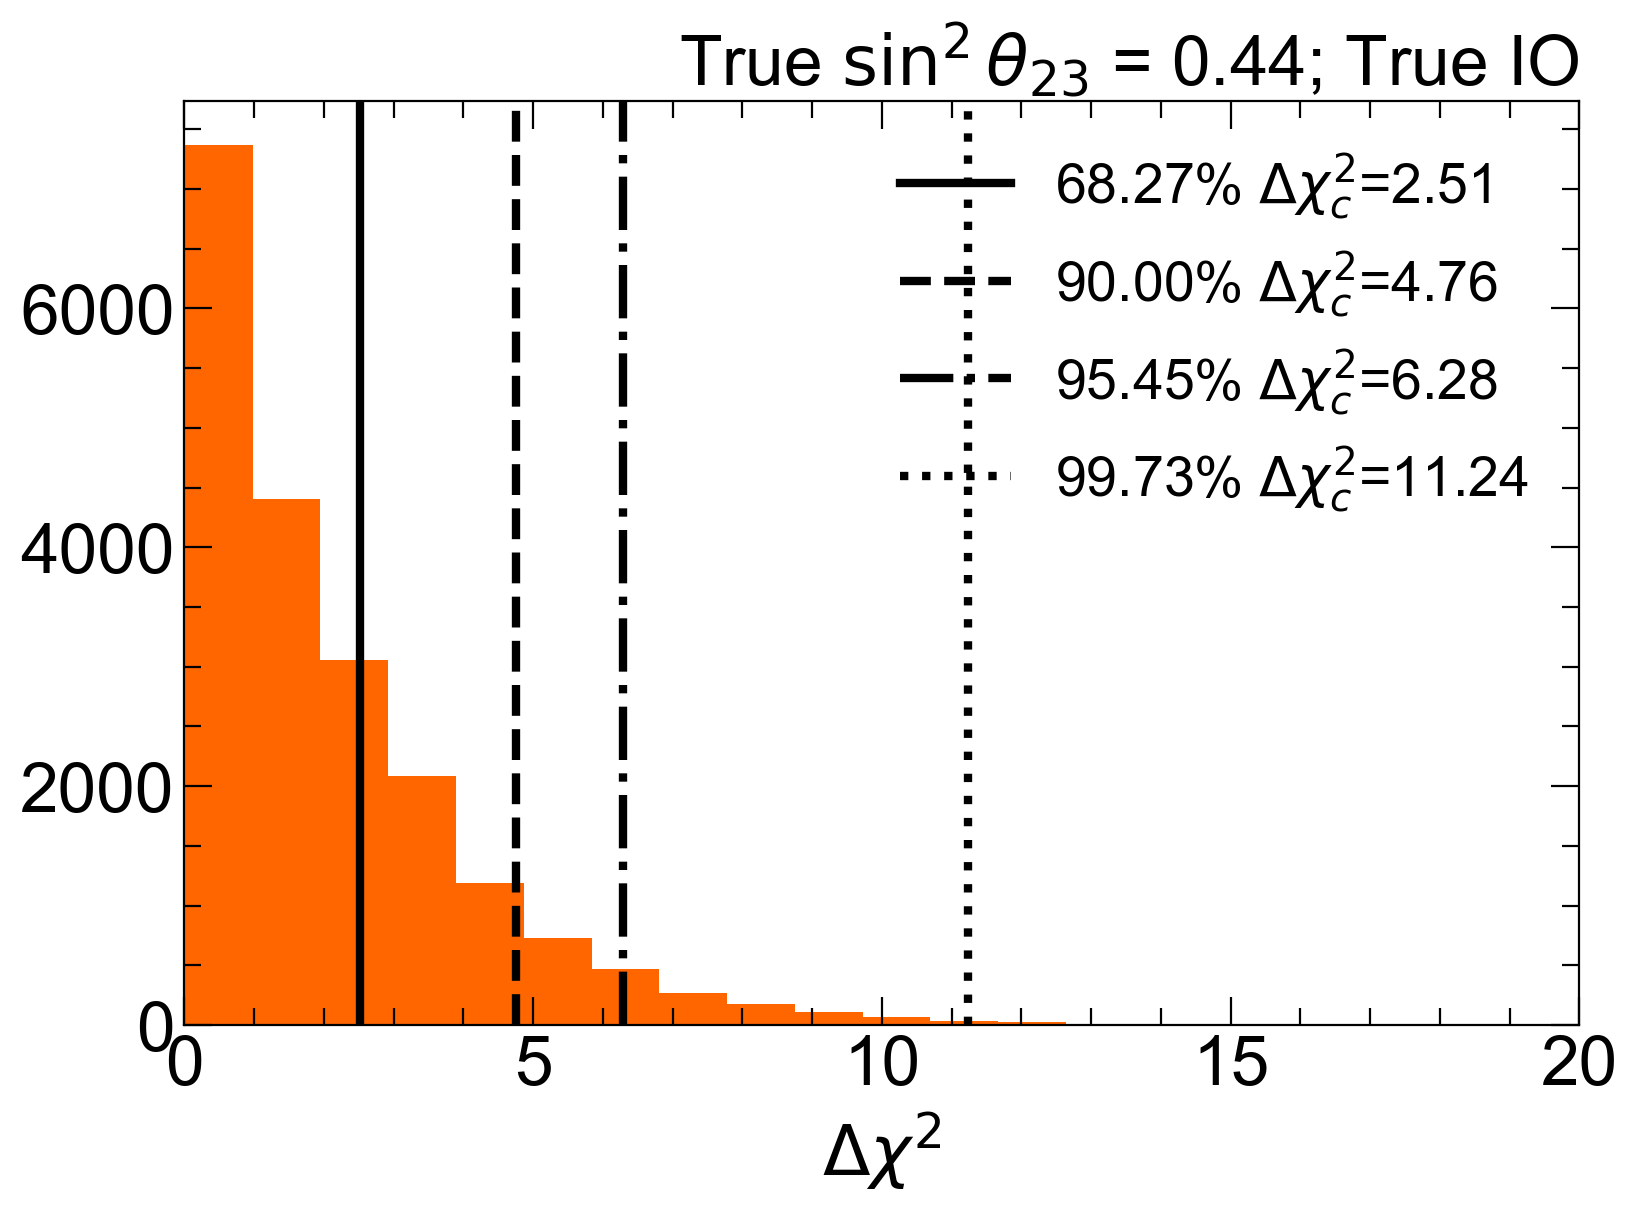

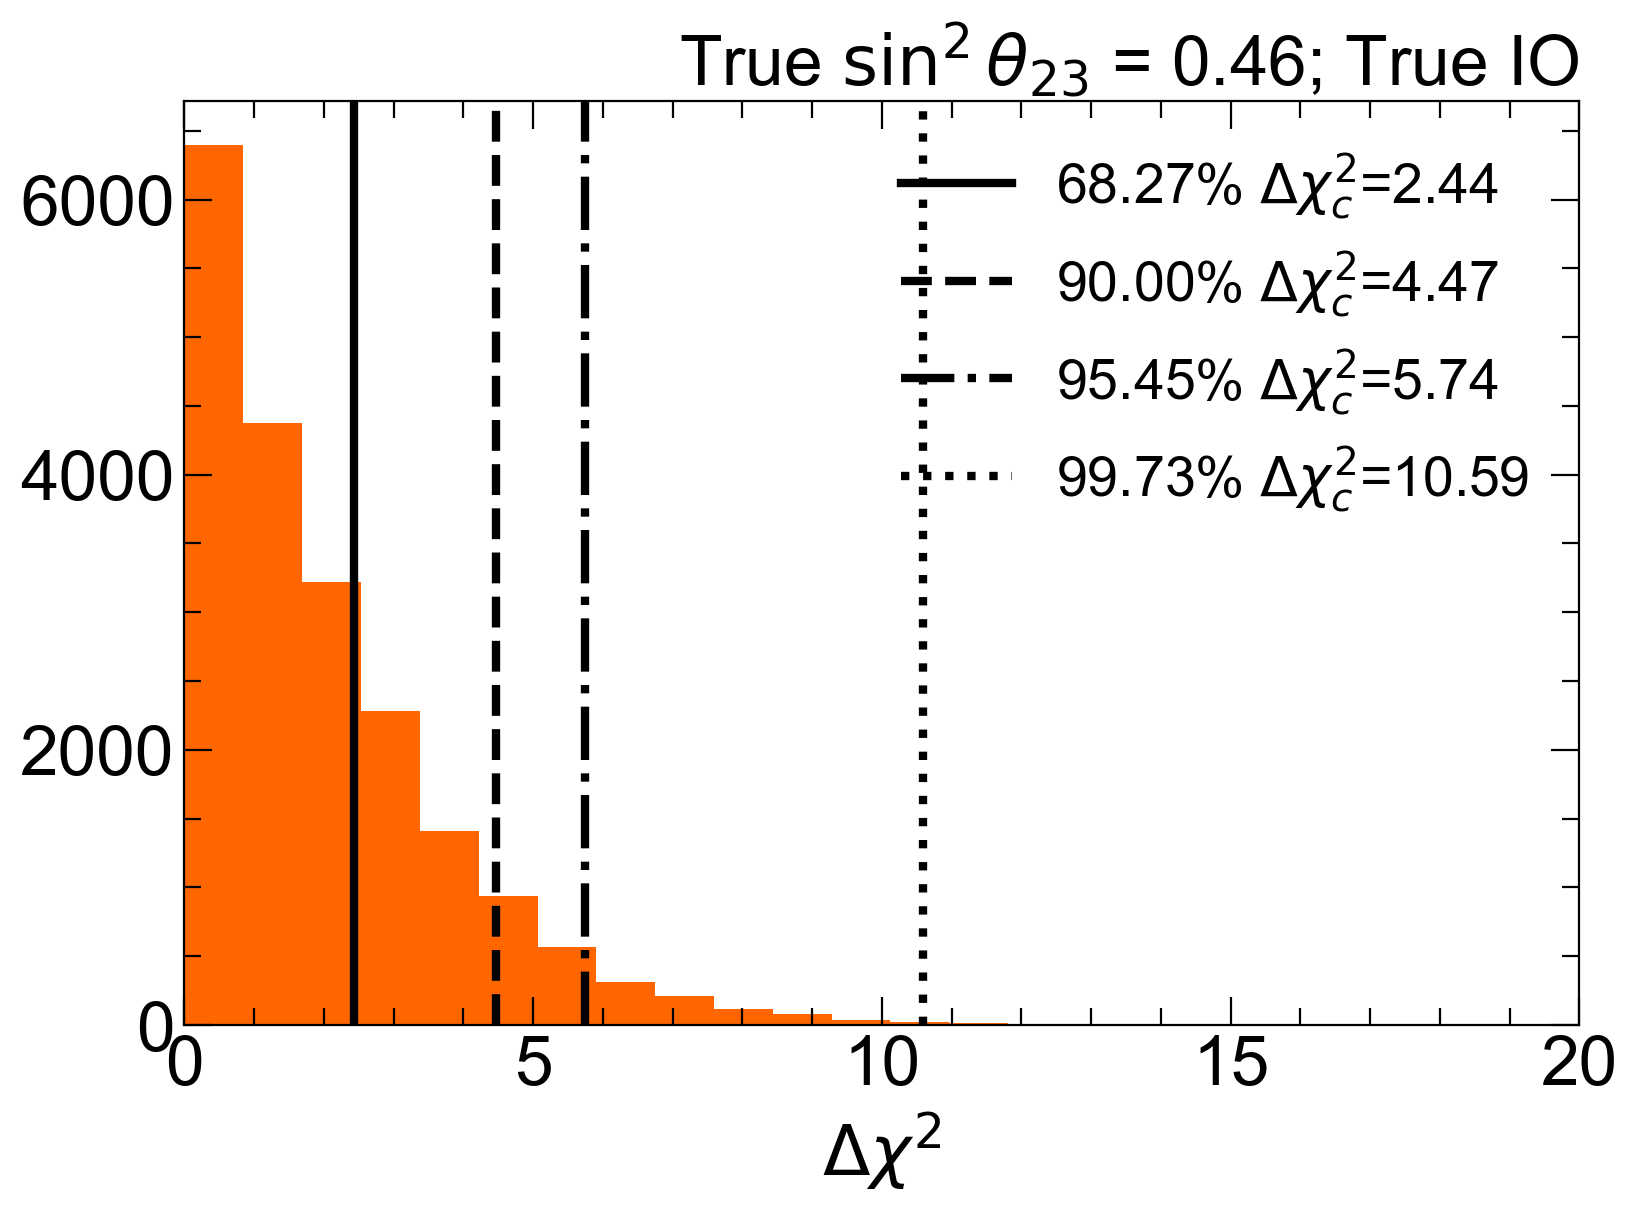

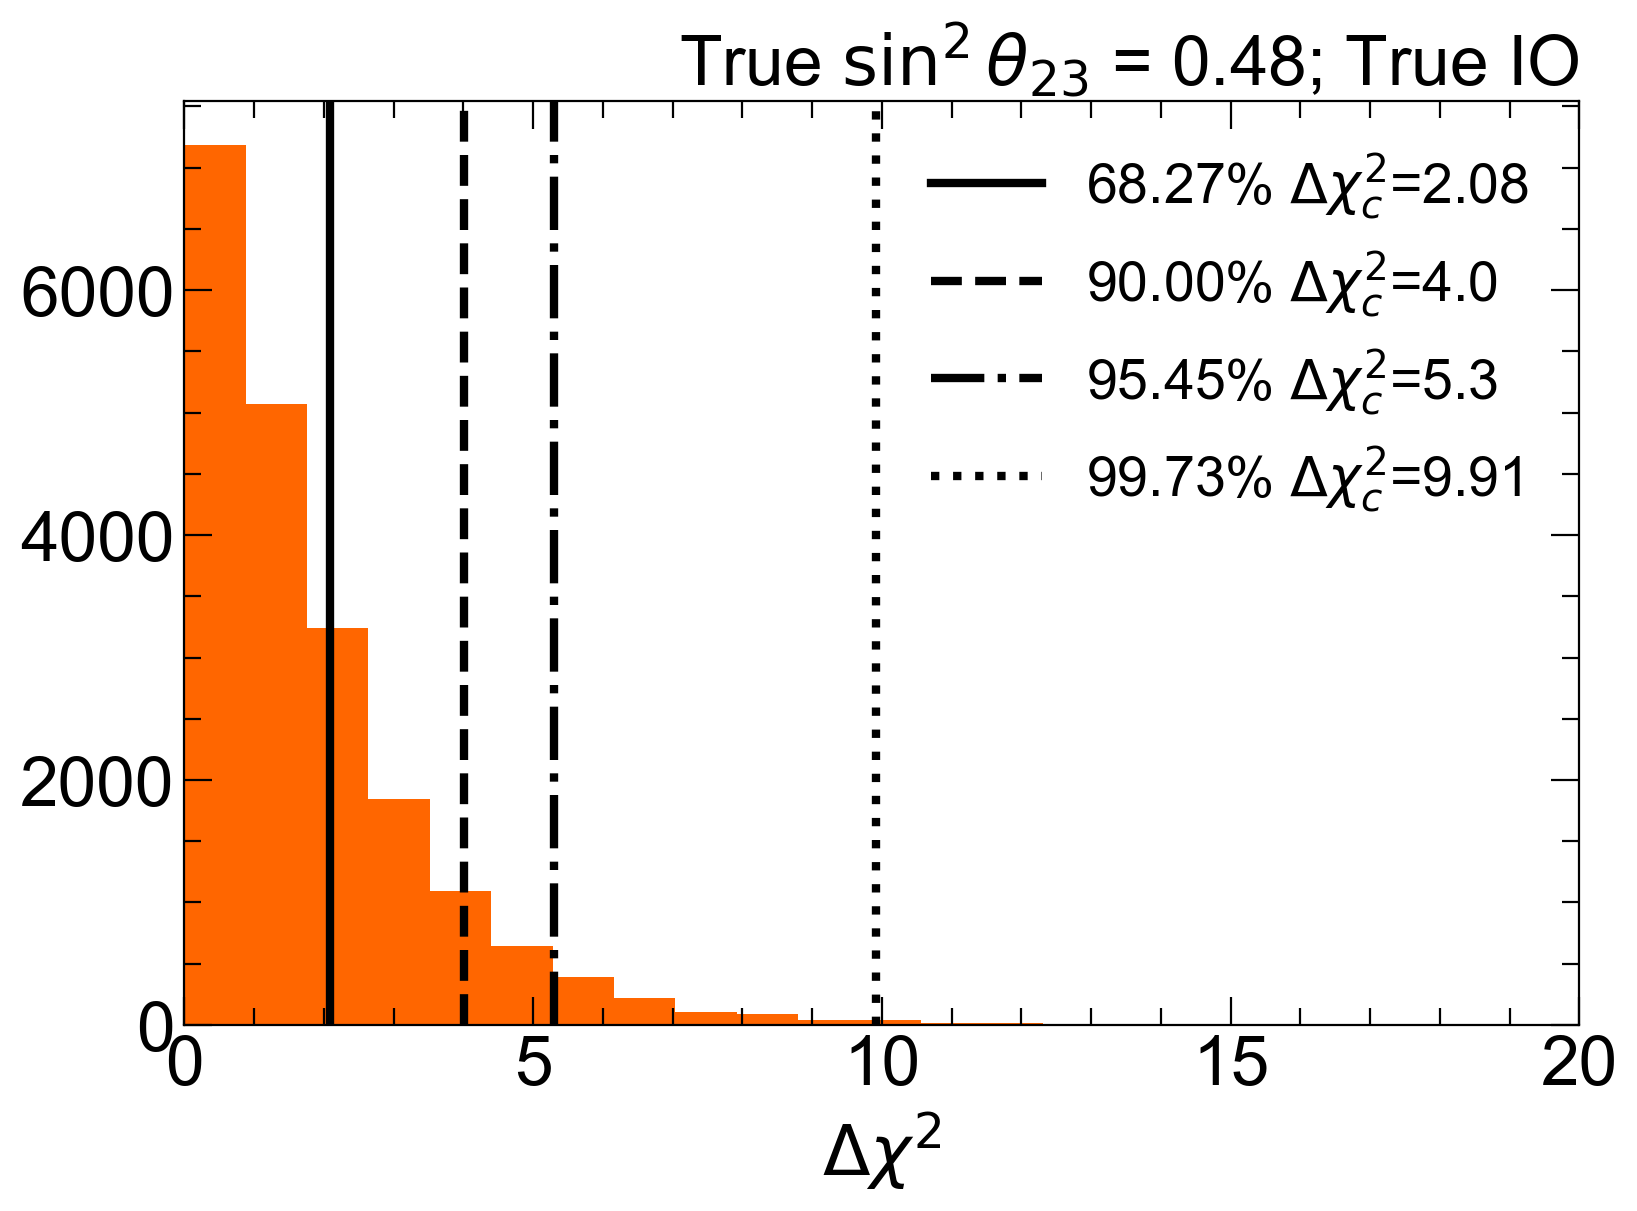

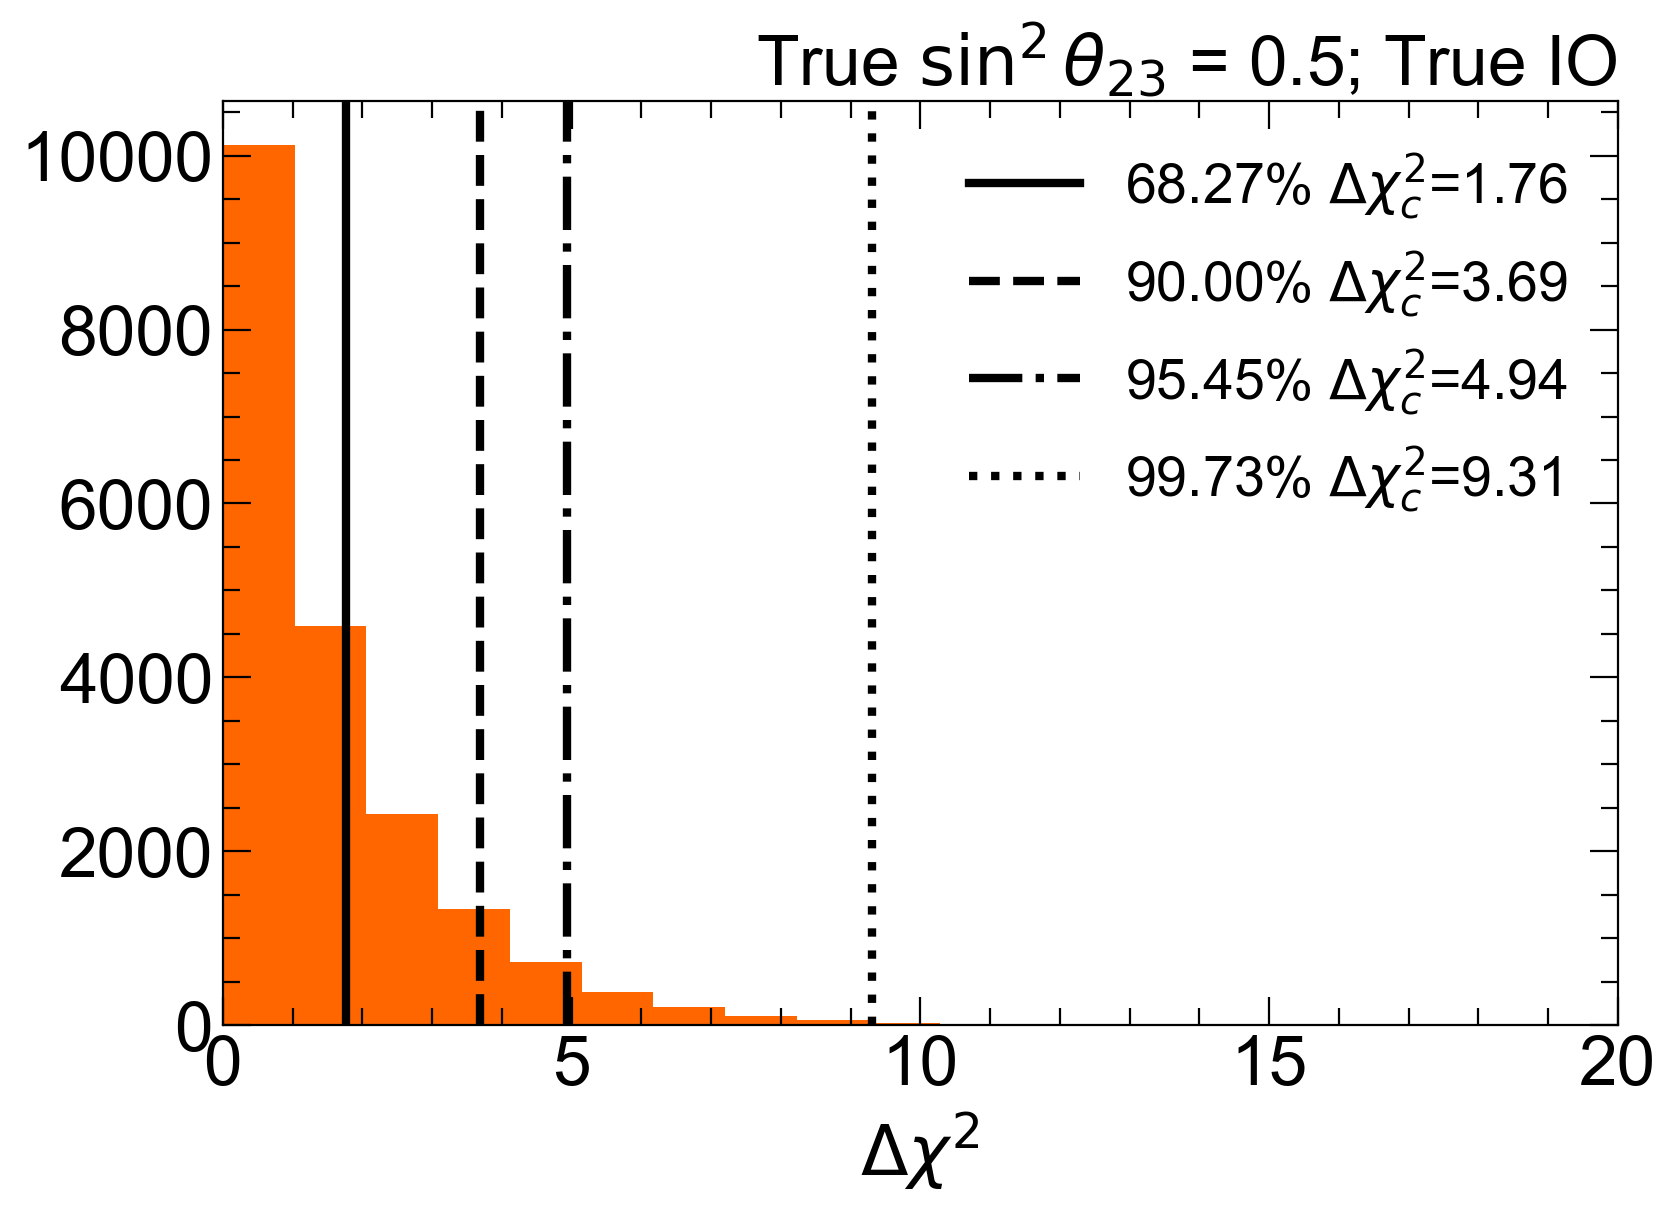

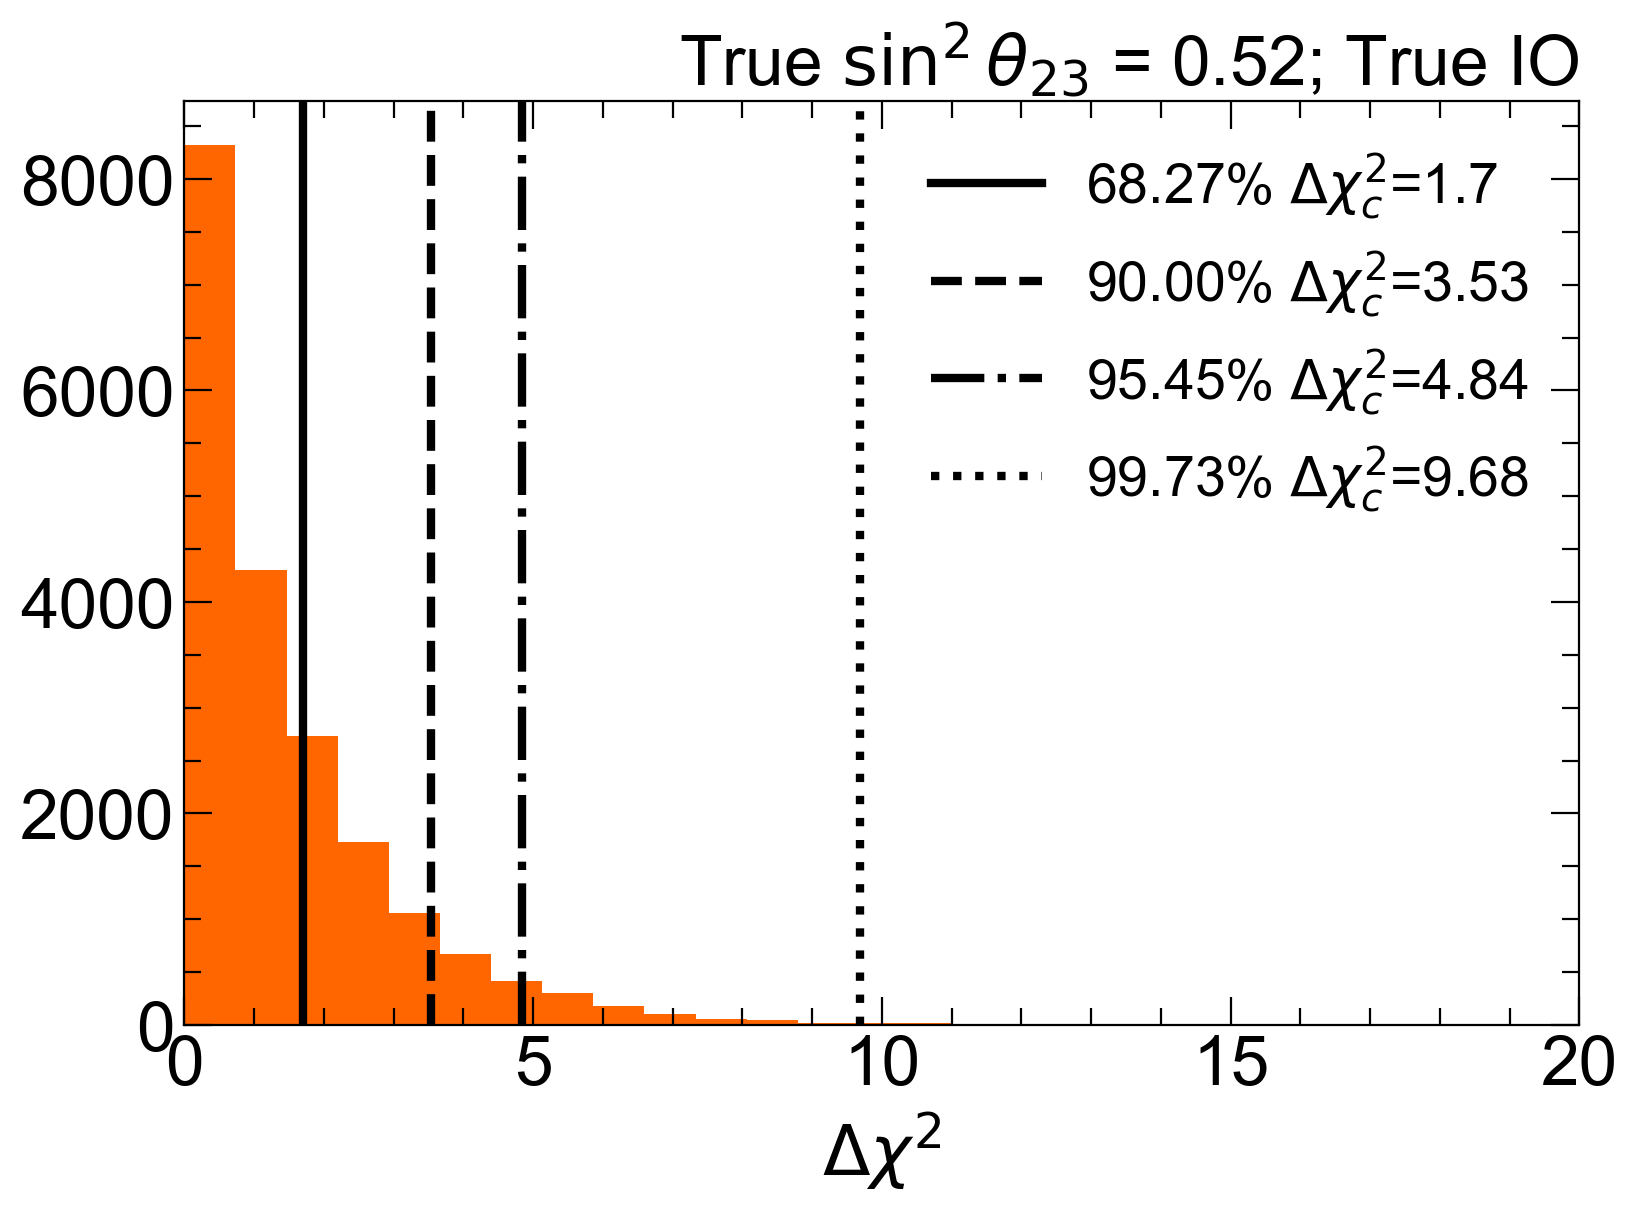

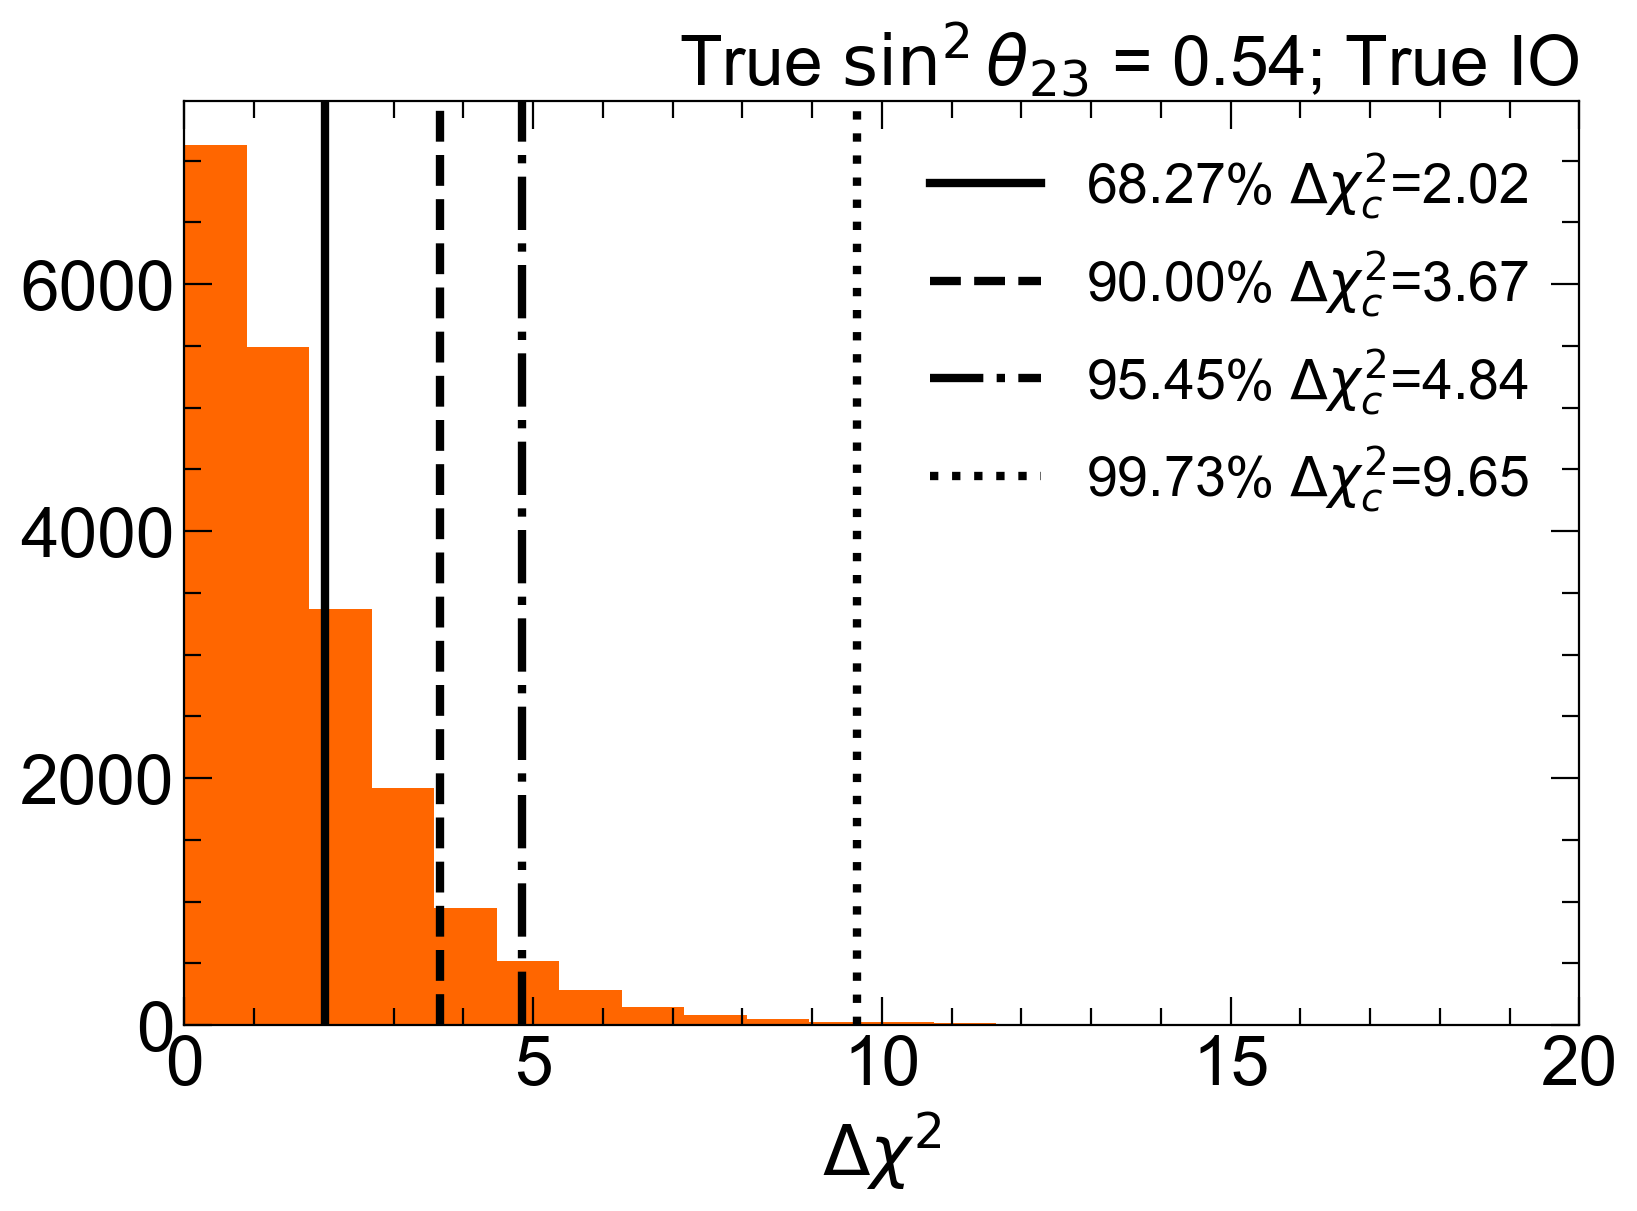

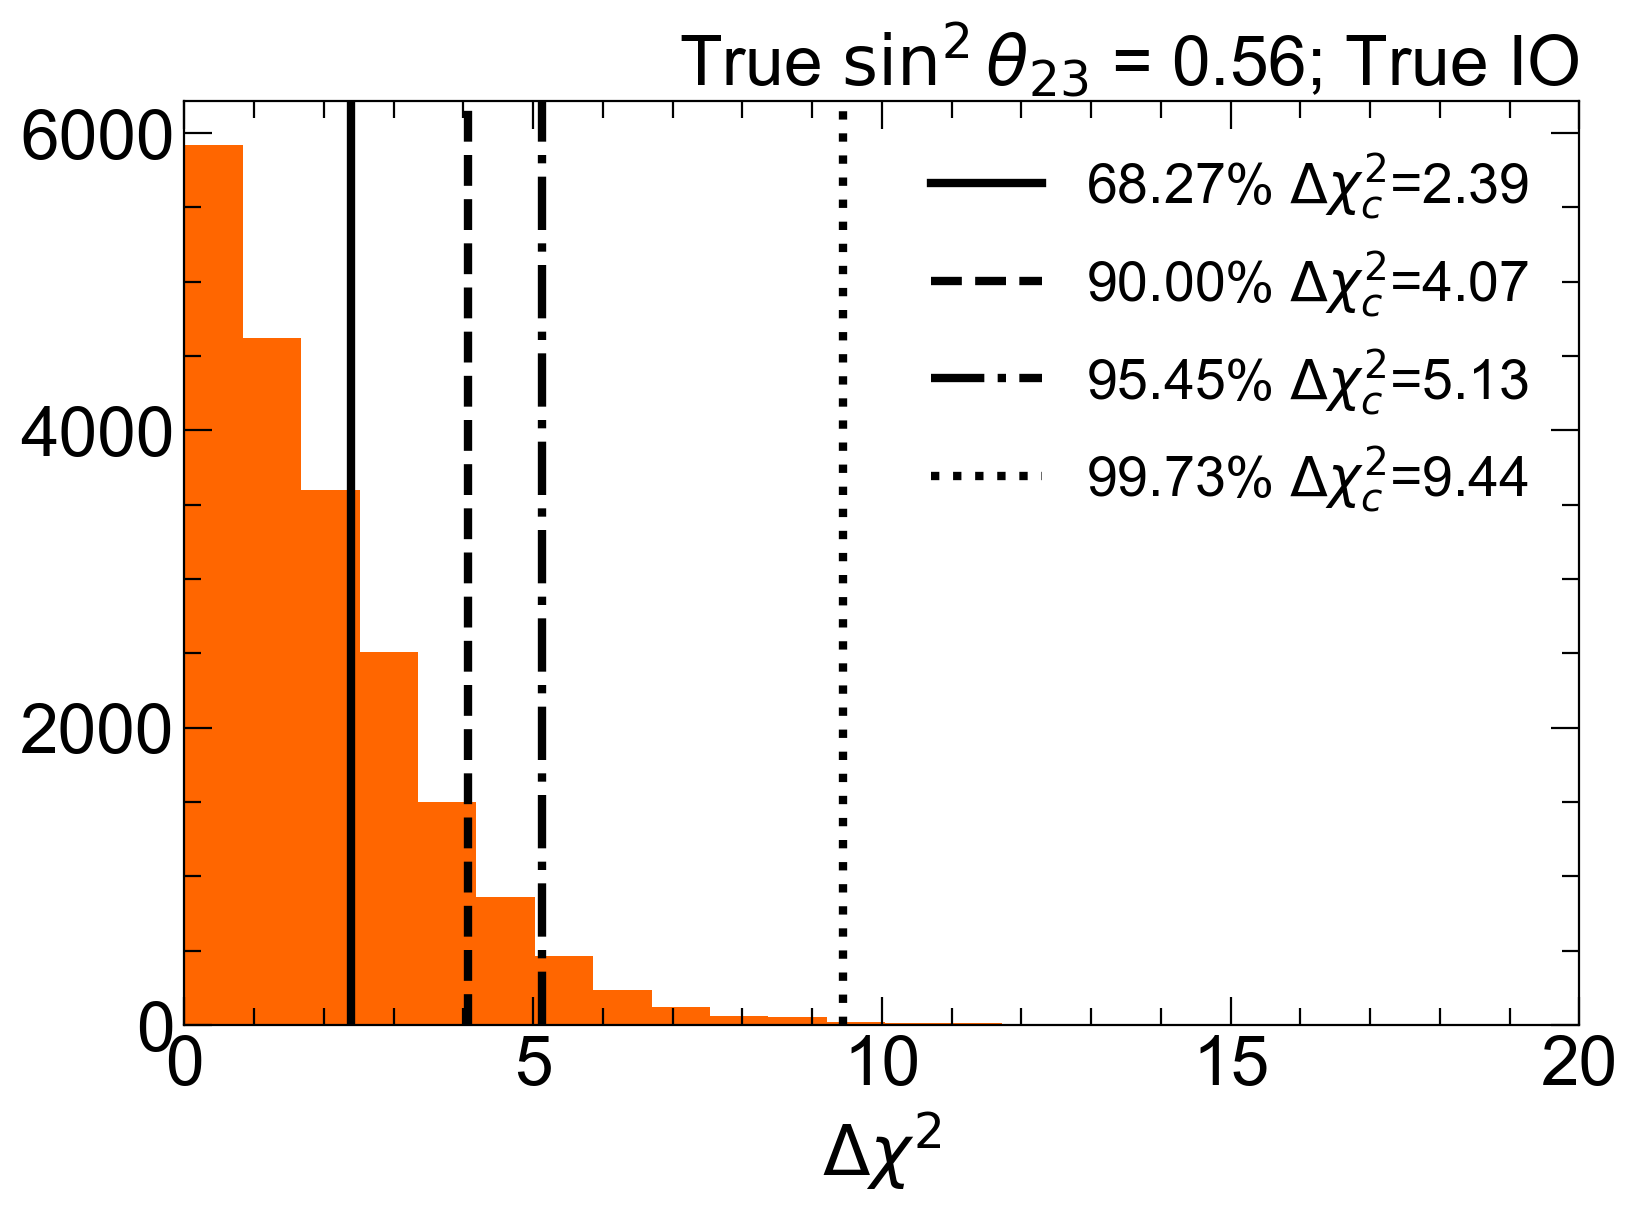

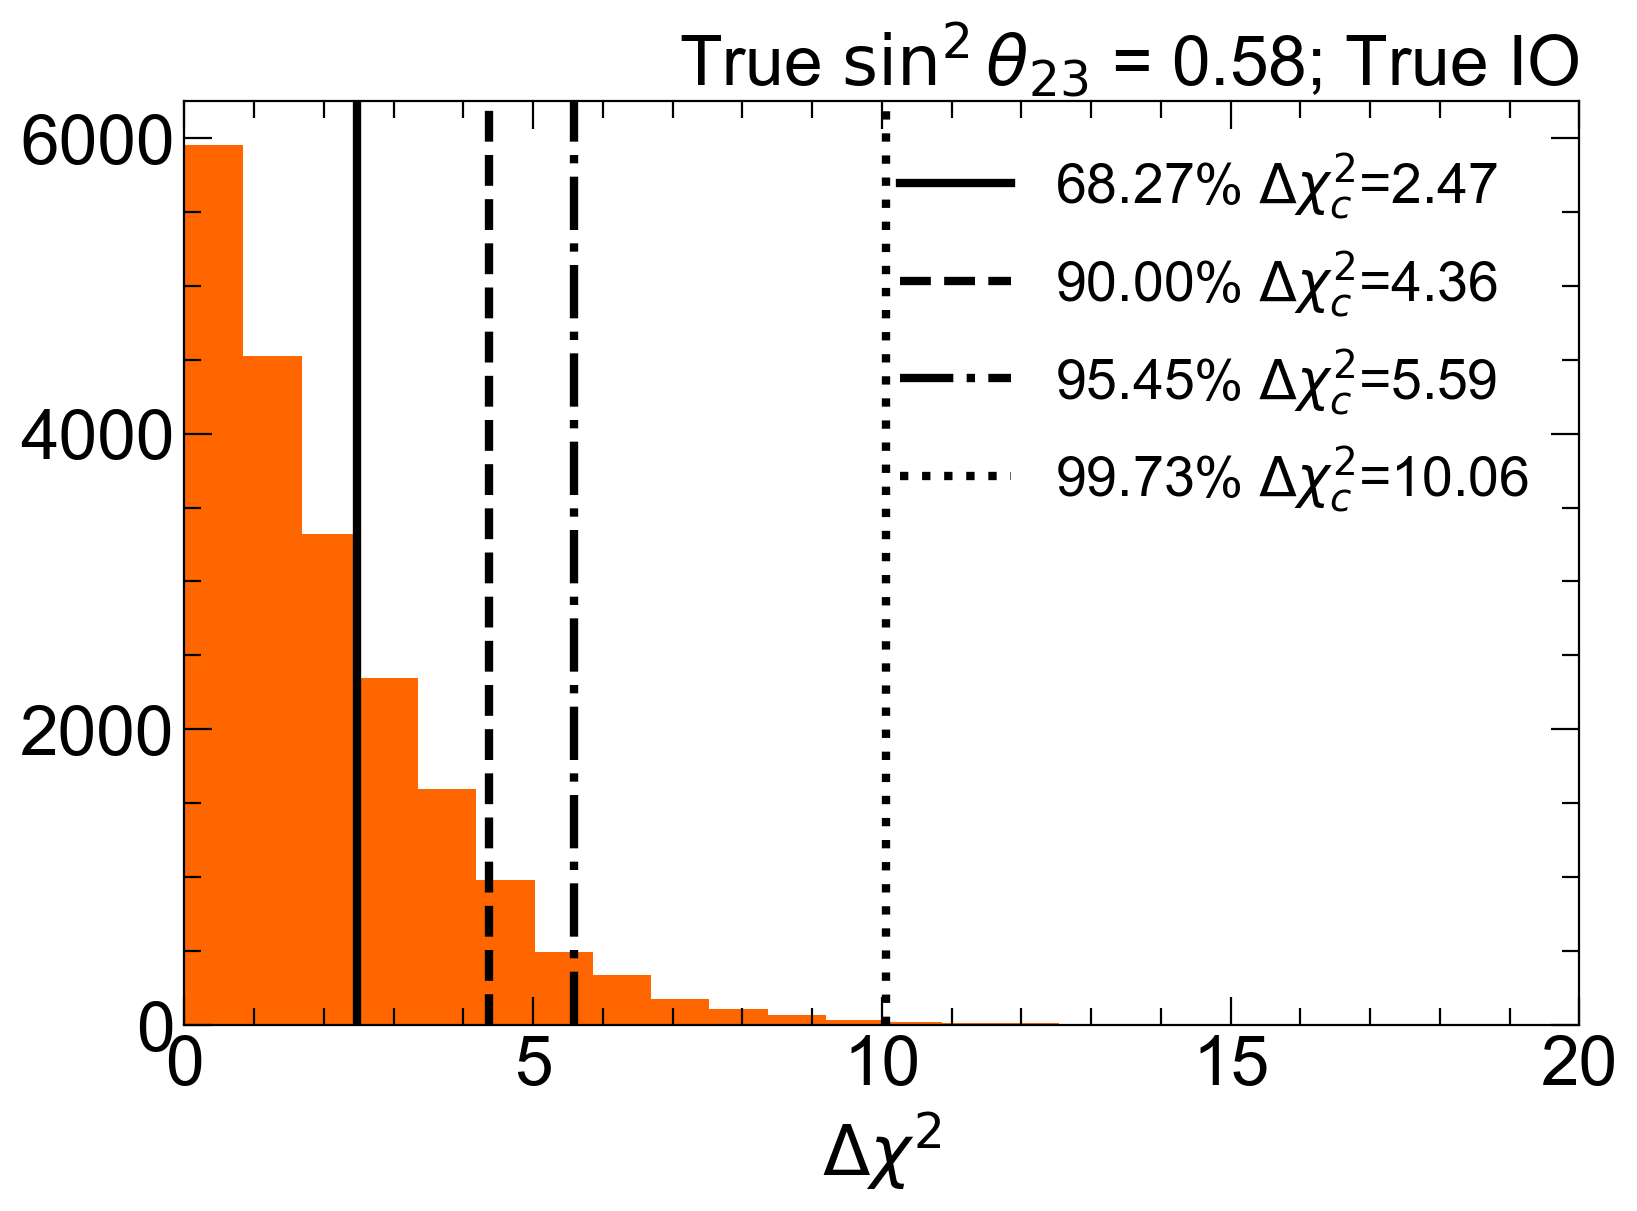

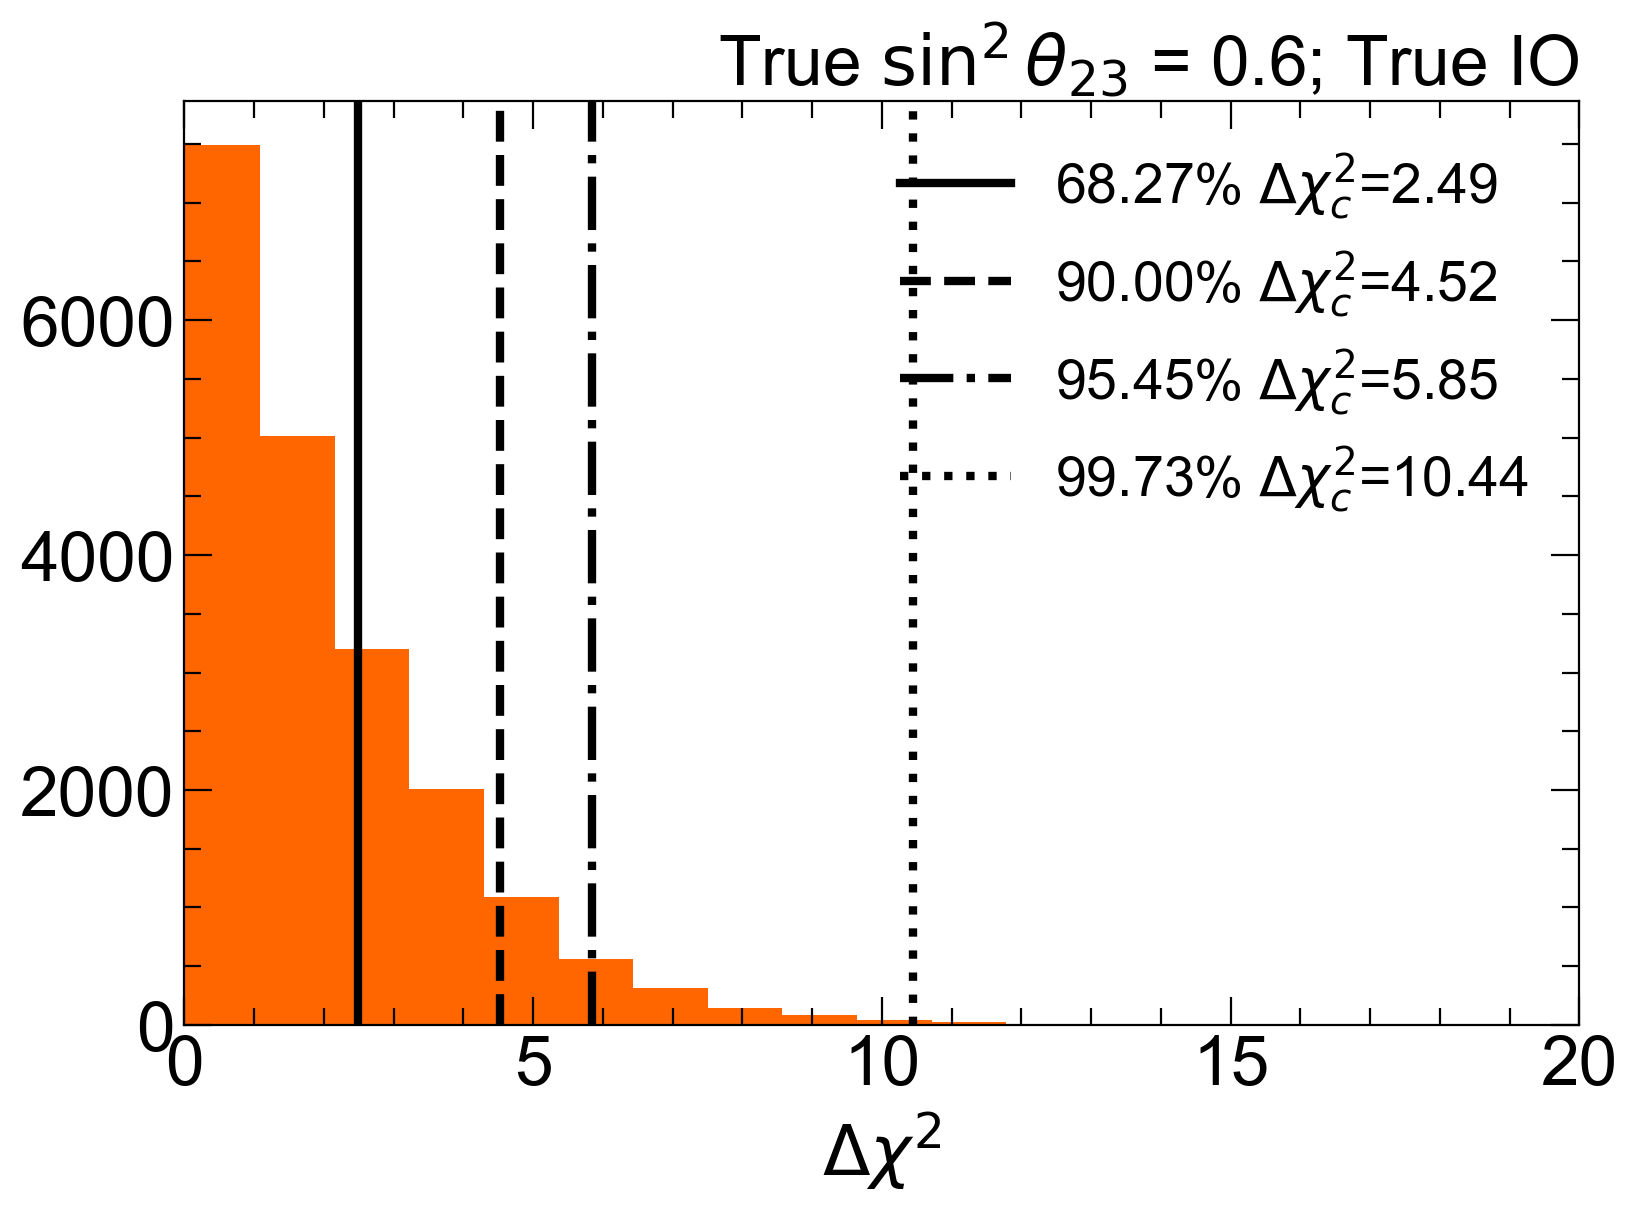

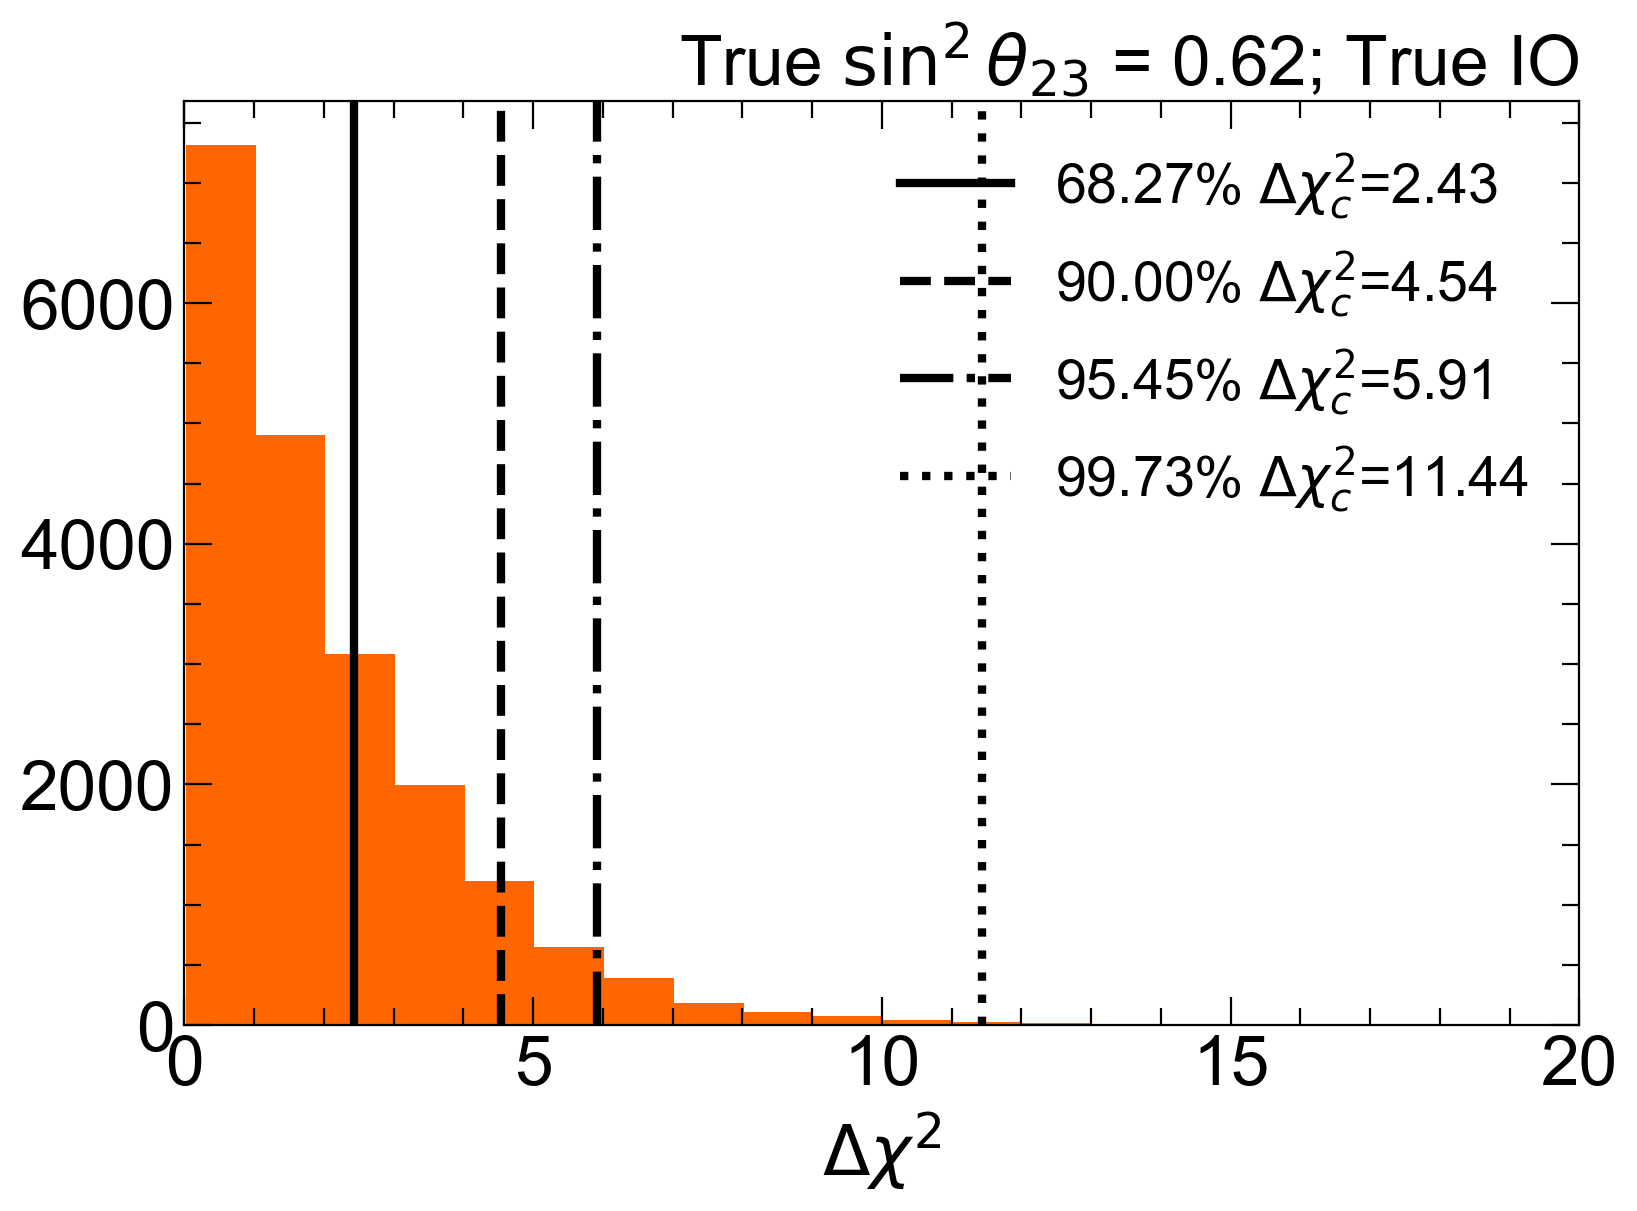

In [47]:
from pythetatools.base_analysis import cl_for_sigma

levels = [cl_for_sigma(z_score) for z_score in [1, 2, 3]]
levels = levels + [0.9]
lss = ['-', '--', 'dashdot', 'dotted']
levels.sort()
labels = ['68.27%', '90.00%', '95.45%', '99.73%']

for true_param_str in param_values[param_name]:
    for true_mh in [1]:
        true_param = float(true_param_str)
        basename_directory = f"MargTemplates_LucileThesis_fit_FC{suffix[param_name]}_{true_param_str}_{true_mh}_FullSyst_wRC_etheta_ptheta_{param_name}"
        dir_ver = 'OA2023'
        
        file_pattern = f"{inputs_dir}/{dir_ver}/FC/{basename_directory}/marg*.root"
        grid_x, param_name_x, AvNLL_pergrid_pertoy = read_files(file_pattern)

        dchi2 = llr_distr(grid_x, AvNLL_pergrid_pertoy, true_param, true_mh, param_name)
        crit_val_centrals, crit_val_lowers, crit_val_uppers = find_crit_val(dchi2, levels)
        plot_dchi2_distr(grid_x, dchi2, param_name_x, true_param, true_mh, levels, crit_val_centrals)
        
        #Write root and mumpy files
        data = {
        "true_mh": [true_mh]*len(levels),
        f"true_{param_name_x}": [true_param]*len(levels),
        "level": levels,
        "Central": crit_val_centrals,
        "Upper": crit_val_uppers,
        "Lower": crit_val_lowers
        }

        data_for_np = np.zeros(len(levels), dtype=[
            ('true_mh', float),
            (f'true_{param_name_x}', float),
            ('level', float),
            ('Central', float),
            ('Upper', float),
            ('Lower', float)
        ])

        # Fill the structured array
        data_for_np['true_mh'] = [true_mh] * len(levels)
        data_for_np[f'true_{param_name_x}'] = [true_param] * len(levels)
        data_for_np['level'] = levels
        data_for_np['Central'] = crit_val_centrals
        data_for_np['Upper'] = crit_val_uppers
        data_for_np['Lower'] = crit_val_lowers
    
        with uproot.recreate(f"{outputs_dir}/files/{dir_ver}/FC/CriticalDchi2_{param_name_x}_{true_param}_truemh{true_mh}.root") as file:
            file["CriticalDchi2"] = data
        np.save(f"{outputs_dir}/files/{dir_ver}/FC/CriticalDchi2_{param_name_x}_{true_param}_truemh{true_mh}.npy", data_for_np)
        #Duplucate +pi to -pi just for easier drawing
        if param_name_x == 'delta' and true_param == 3.14159265359:
            source_file = f"{outputs_dir}/files/{dir_ver}/FC/CriticalDchi2_{param_name_x}_{true_param}_truemh{true_mh}.npy"
            destination_file = f"{outputs_dir}/files/{dir_ver}/FC/CriticalDchi2_{param_name_x}_-{true_param}_truemh{true_mh}.npy"
            shutil.copy(source_file, destination_file)

# Plot the critical values in ROOT file

In [42]:
delta_values_wmpi = [-3.14159265359]+ list(map(float, delta_values))
delta_values_wmpi.sort()

true_sin223_grid_sorted = list(map(float, sin223_values))
true_sin223_grid_sorted.sort
true_param_grid_sorted = {'delta':delta_values_wmpi, 'sin223':true_sin223_grid_sorted}

mo_level_to_color = {0: {0.6827: lightblue, 0.9: midblue, 0.9545: darkblue, 0.9973: 'darkblue'}, 
          1: {0.6827: lightorange, 0.9: midorange, 0.9545: darkorange, 0.9973: 'brown'}}

In [43]:

def plot_crit_val(ax, param_name_x, true_param_grid_sorted, true_mh):
    crit_val_central = defaultdict(list)
    crit_val_lower = defaultdict(list)
    crit_val_upper = defaultdict(list)
    levels = []
    for true_param in true_param_grid_sorted:
        data = np.load(f"{outputs_dir}/files/{dir_ver}/FC/CriticalDchi2_{param_name_x}_{true_param}_truemh{true_mh}.npy")
        for i, level in enumerate(data['level']):
            crit_val_central[level].append(data['Central'][i])
            crit_val_lower[level].append(data['Lower'][i])
            crit_val_upper[level].append(data['Upper'][i])
        levels = data['level']

    for level in levels:
        ax.plot(true_param_grid_sorted, crit_val_central[level], color=mo_level_to_color[true_mh][level], marker='o', linewidth=2, label=f'{round(level*100, 2)}%')
        ax.plot(true_param_grid_sorted, crit_val_lower[level], color=mo_level_to_color[true_mh][level],  linewidth=1)
        ax.plot(true_param_grid_sorted, crit_val_upper[level], color=mo_level_to_color[true_mh][level],  linewidth=1)

    ax.set_ylim(0, 11)
    ax.set_xlim(true_param_grid_sorted[0], true_param_grid_sorted[-1])
    ax.set_xlabel(osc_param_title[param_name_x][0])
    ax.set_ylabel(r'$\Delta \chi^2_c$')
    
    ax.axhline(1, ls='--', color='grey', linewidth=2)
    ax.axhline(4, ls='--', color='grey', linewidth=2)
    ax.axhline(9, ls='--', color='grey', linewidth=2)
    ax.axhline(critical_value_for_cl(0.9, dof=1), ls='--', color='grey', linewidth=2)
    
    show_minor_ticks(ax)
    ax.legend(ncol=4, fontsize=15, loc='upper center')
    

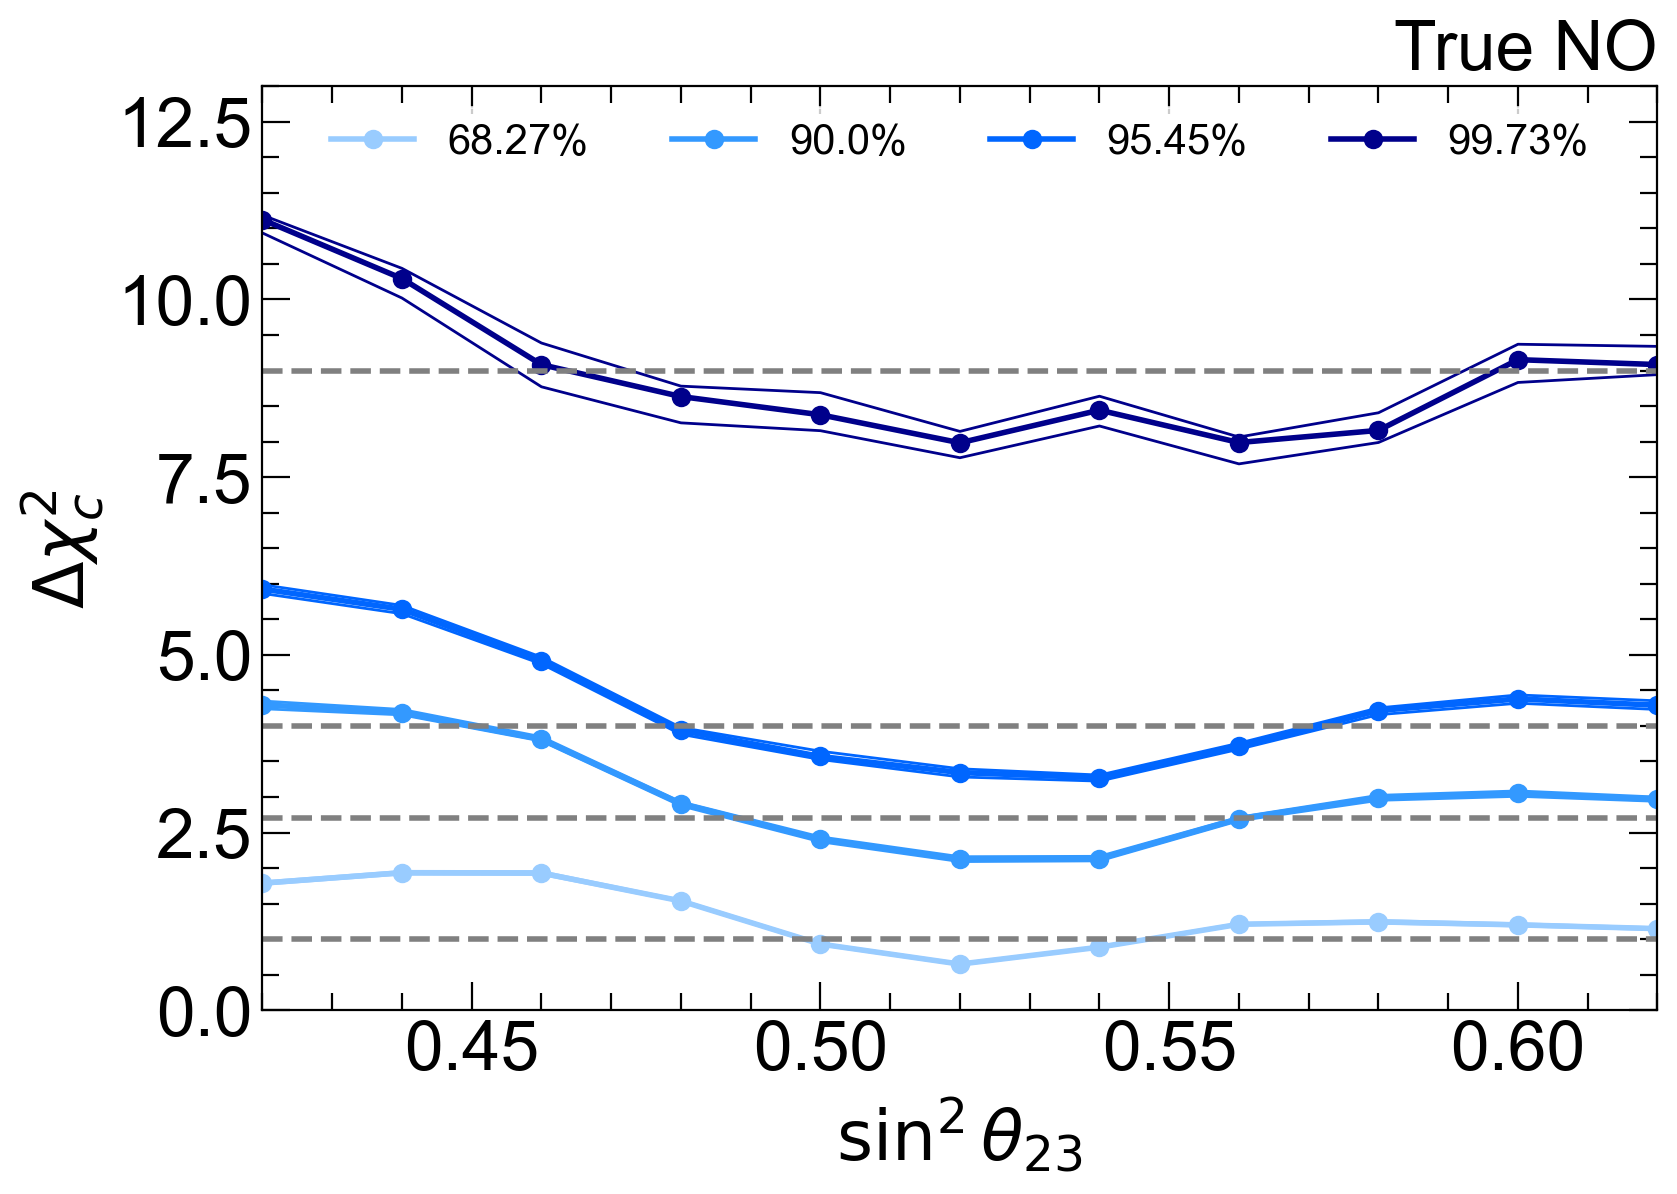

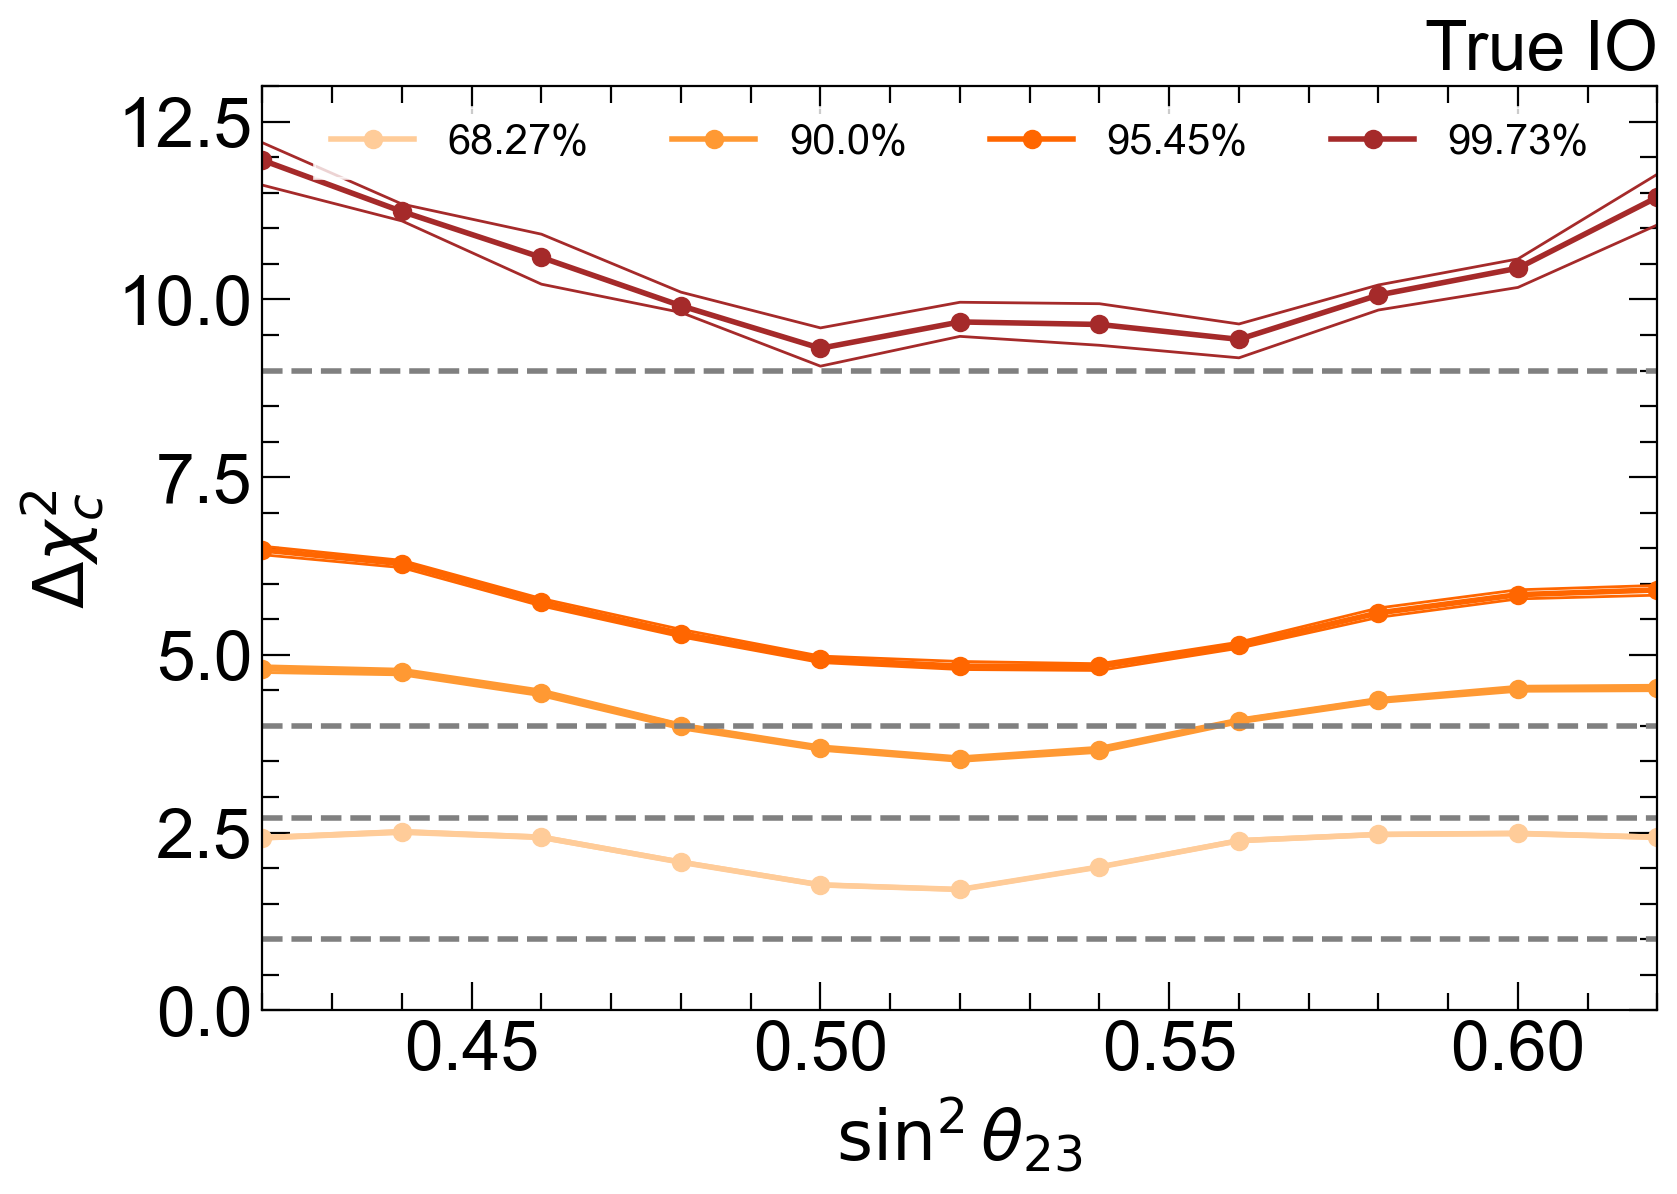

In [51]:
for true_mh in [0, 1]:
    fig, ax = plt.subplots()
    plot_crit_val(ax, param_name, true_param_grid_sorted[param_name], true_mh)
    ax.set_title(f'True {mo_to_title[true_mh]}', loc='right')
    ax.set_ylim(0, 13)